In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

### Gather Data

In [2]:
df = pd.read_csv('MLClassData.csv')
df.shape

(308634, 203)

### Visualize Data ###

In [5]:
df.iloc[:5,20:30]

,d1w3,d1w3pmdiff,dm__15range-dm__1close2diff,dvwapday1_m5vol,dvwapday_accvol,dvwapday_accvolpmdiff,gapatr,high10atr,high10atrpmbetadiff,high20drange
0,1.749994,-3.583335,2.959070,-3.270143,-0.533356,-25.701912,1.188645,1.805533,1.769799,0.959334
1,1.749994,-3.583335,2.959070,-2.970276,-0.534154,-25.695157,1.188645,1.720273,1.684539,0.968693
2,6.499484,1.166155,3.705569,-20.245816,-1.105624,-1.696067,-0.093103,0.204828,0.199714,0.285713
3,0.255639,-5.077691,4.877921,-14.787942,-0.495554,-0.979505,0.402122,0.209805,0.148927,0.153846
4,0.255639,-5.077691,4.877921,-23.929751,-0.458448,-0.881268,0.402122,0.166096,0.148338,0.129354


In [6]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'account', 'avg_min_dol_vol',
       'avgminhigh', 'avgminlow', 'close1', 'close10', 'close11', 'close12',
       ...
       'matched_shares', 'medminhigh', 'medminlow', 'mtm_pl', 'q1minhigh',
       'q1minlow', 'q3minhigh', 'q3minlow', 'symbol', 'vwap_close'],
      dtype='object', length=203)

In [8]:
### Define Features to Train Model on ###
features = list(pd.read_csv('FilteredClfFeatsBF100_50.csv')['Clf Features'])
features

['minscd3/minsd3rvold',
 'minscd4/minsd1rvold',
 'zl1_last-zmo_ema2/dailyrange',
 'mdtwomean',
 'minscd5-minsd5rvold',
 'vdaily_range',
 'zl1_last-zmo_midprice2/dailyrange',
 'md1w6',
 'gapatr',
 'mdbw3',
 'ztmins_from_close',
 'high10atr',
 'high20drange',
 'mdbw1*beta',
 'minscd5rvol/minsod5rvold',
 'zmms_linearreg_slope_prev2-zms_tsf_prev0',
 'zl1_daily_vwap-zdo_tema0/dailyrange',
 'mweek4rangevol',
 'minscd2',
 'mweekrangevol',
 'zdv_ad_change1pmdiff',
 'zmdo_tema_change0/atr*zdm_fastkrsi_change1',
 'mdtwmean',
 'minscd2rvold/minsd0rvold',
 'mdtwomax',
 'mtd0d2_rvol',
 'mgap',
 'highlastt',
 'mdbwomax',
 'zms_linearreg0-zms_linearreg_change1',
 'openvwaplast_rvol',
 'avol',
 'md1w9',
 'zmms_stddev_prev2-zms_linearreg_slope_slope0',
 'zdo_ema_change2/atr*zdm_cci2',
 'mdbwmax',
 'mdtwo4',
 'mweek3rangeatr',
 'mrvol',
 'mtd0d1*accvol',
 'mdtw1',
 'vvwapopen_accvol',
 'spreadday']

In [9]:
# Check type of each feature is float
print('Data Types:')
for i in features:
    t = df[i].dtype
    if t != float:
        print(i, t)
        features.remove(i)

Data Types:


In [13]:
# Check for null values 
print('Null Columns:')
for i in features:
    c = df[i].isnull().sum() / float(len(df))
    if c > 0.95:
        print(i, c)
        features.remove(i)

Null Columns:


In [14]:
# Check for zero values
print('Zero Columns:')
for i in features:
    n = (df[i] == 0).astype(int).sum() / float(len(df))
    if n > 0.95:
        print(i, n)
        features.remove(i)

Zero Columns:


In [15]:
# Check unique values in each feature
print('Unique Values:')
for i in features:
    u = len(df[i].unique()) / float(len(df))
    if u < 0.1:
        print(i, u)

Unique Values:
mdtwomean 0.0057219878561662035
vdaily_range 0.06939935327928874
md1w6 0.005563223753701795
mdbw3 0.00559562459093943
mweek4rangevol 0.0057219878561662035
mweekrangevol 0.0057219878561662035
zmdo_tema_change0/atr*zdm_fastkrsi_change1 0.004111666245455782
mdtwmean 0.00570902752127115
mdtwomax 0.001979691155219451
mgap 0.0025078248021928886
mdbwomax 0.001999131657562031
md1w9 0.0712008398297012
mdbwmax 0.0019926514901145048
mdtwo4 0.005666906432862225
mweek3rangeatr 0.0057219878561662035
mdtw1 0.0054984220792265275


### Label Data with Different Classes

In [16]:
### Define Objective and Label ###
df['maxreturn'] = (df.high - df.entry_price) / df.zv_length
df['label'] = (df.maxreturn > 0.4).astype(int)

In [21]:
### Look at return details ###
print('Percent of Target Trades:', df.label.sum() / float(len(df)))

Percent of Target Trades: 0.267964644206


### Split Data into Training and Testing Sets

In [36]:
### Split the data into training, testing sets ###
train = df[(pd.to_datetime(df.entry_time) < pd.to_datetime('2017-01-01')) & 
           (pd.to_datetime(df.entry_time) >= pd.to_datetime('2014-01-01'))]
test = df[pd.to_datetime(df.entry_time) >= pd.to_datetime('2017-01-01')]

X_train = train.loc[:,features]
y_train = train.loc[:,'label']

X_test = test.loc[:,features]
y_test = test.loc[:,'label']

print('Length of Training Set: ' + str(len(train)))
print('Length of Testing Set: ' + str(len(test)))

Length of Training Set: 147386
Length of Testing Set: 69202


### Clean and Standardize Data

In [23]:
### Remove null values and replace with the median of each column ###
transform = Imputer(missing_values='NaN',strategy='median')

### Find median of each column in training set and replace null values ###
X_train = transform.fit_transform(X_train)

### Apply median from training set to null values of test set ###
X_test = transform.transform(X_test)

### Train Random Forest

In [29]:
### Train and fit classifier to Training Data ###
clf = RandomForestClassifier(n_estimators=200, max_depth=10, max_leaf_nodes=100, n_jobs=-1, verbose=1)

clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=100,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [30]:
y_pred = clf.predict_proba(X_test)
y_pred.sum()

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished


7327

In [31]:
trades = test.assign(pred = y_pred)
trades = trades[trades.pred > 0.5]

In [32]:
print('Original Max Return - No ML')
print(test.maxreturn.describe())
print('---------------')
print('Max Return with ML')
print(trades.maxreturn.describe())

Original Max Return - No ML
count    69200.000000
mean         0.309639
std          0.297807
min         -1.654131
25%          0.095233
50%          0.238095
75%          0.444445
max          7.350002
Name: maxreturn, dtype: float64
---------------
Max Return with ML
count    7327.000000
mean        0.519106
std         0.431170
min        -1.654131
25%         0.213973
50%         0.450262
75%         0.742974
max         3.444437
Name: maxreturn, dtype: float64


Original PnL - No ML


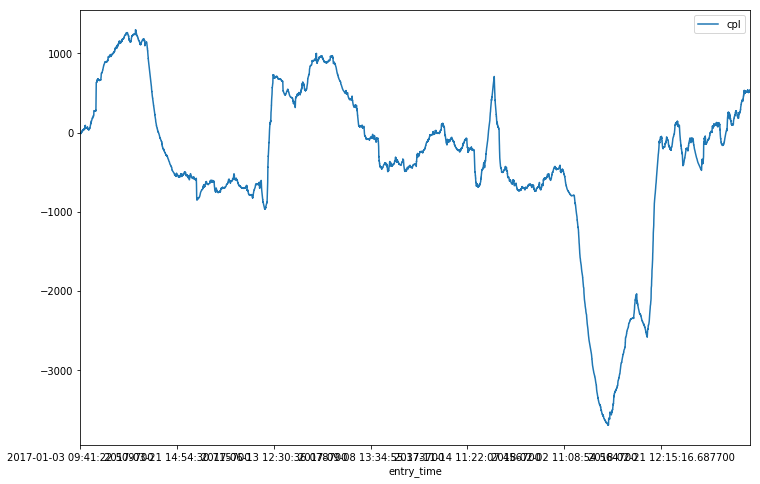

----------------
PnL with ML


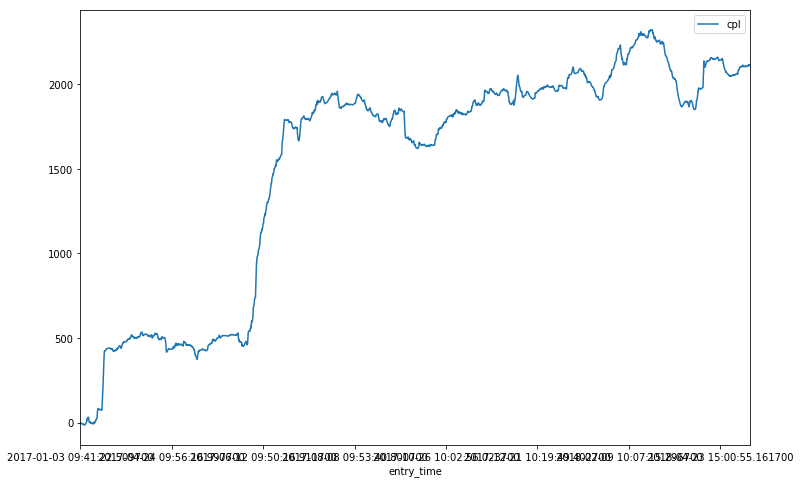

In [33]:
trades = trades.sort_values('entry_time')
trades['cpl'] = trades.mtm_pl.cumsum()
test = test.sort_values('entry_time')
test['cpl'] = test.mtm_pl.cumsum()
print('Original PnL - No ML')
test.plot(x='entry_time',y='cpl',figsize=[12,8])
plt.show()
print('----------------')
print('PnL with ML')
trades.plot(x='entry_time',y='cpl',figsize=[12,8])
plt.show()

In [34]:
### Feature Importances ###
importances = sorted(list(zip(clf.feature_importances_, features)),reverse=True)
for i, f in importances:
    print(f, i)

minscd3/minsd3rvold 0.0836191977425
minscd4/minsd1rvold 0.0787717117044
highlastt 0.0630715736456
minscd2 0.0618851364907
minscd5-minsd5rvold 0.057315901154
ztmins_from_close 0.0529302306735
high10atr 0.0465824529988
high20drange 0.0422191810606
minscd2rvold/minsd0rvold 0.0324615235945
mdbwmax 0.0302479607436
minscd5rvol/minsod5rvold 0.0297132106729
mdtwomean 0.0250349531597
zmms_linearreg_slope_prev2-zms_tsf_prev0 0.0237351497252
mdtwmean 0.0228675909391
zmdo_tema_change0/atr*zdm_fastkrsi_change1 0.0228196343988
zl1_last-zmo_midprice2/dailyrange 0.0214179723196
zdv_ad_change1pmdiff 0.0208508280668
mgap 0.0203791340187
md1w6 0.0196039491465
mdbwomax 0.0190108593949
zl1_last-zmo_ema2/dailyrange 0.0187950332149
mrvol 0.018315029297
openvwaplast_rvol 0.0182670120578
mdbw3 0.0171693676075
mweek3rangeatr 0.0152726019396
mdtwomax 0.0143184435186
mweekrangevol 0.0141299216445
mdtwo4 0.0129327866942
vdaily_range 0.0129264018475
mweek4rangevol 0.012708886201
md1w9 0.0111755263646
zl1_daily_vwap

## Gradient Boosted Model

In [106]:
data = lgb.Dataset(X_train, y_train)
param = {'max_depth':6, 'num_leaves':10, 'learning_rate':0.01, 'num_threads':-1,
         'min_data_in_leaf':100, 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
bst = lgb.train(param, data, 500)

In [107]:
y_pred = bst.predict(X_test)
y_pred.sum()

18057.297662074401